In [30]:
# Import libraries and dependencies
import os
import pandas as pd
from pathlib import Path
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
%matplotlib inline

In [31]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

True

In [32]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

ValueError: ('Key ID must be given to access Alpaca trade API', ' (env: APCA_API_KEY_ID)')

In [33]:
def days_to_trading_days(days):
    return round(days * 252 / 365)

def trading_days_to_days(trading_days):
    return round(trading_days * 365 / 252)

In [29]:
def get_barset_amzn(start_date, end_date):
    """
    Gets alpaca barset for AMZN with 1D timeframe for the given dates
    and returns the data in a pandas dataframe.
    
    If the num of days is greater than 1000, it makes more than one api
    call and combines the responses in a single dataframe.
    """
    # Initialize a variable `df` to store the final dataframe.
    df = None;
    
    # Calculate the num of days in the given start and end dates
    days = (end_date - start_date).days
    
    # Convert num of days into num of trading days
    trading_days = days_to_trading_days(days)
    
    # Calculate the num of calls to make
    # e.g. for 1500 trading days we need to make at least 2 api calls
    # trading_days = 1500, round(trading_days/1000) = 1, num_api_calls = 1 + 1 = 2
    num_api_calls = 1 + round(trading_days/1000)
    
    # 252 trading days = 365 normal days
    # 1000 trading days = 1000 * 365 / 252 normal days
    days_per_1k_trading_days = trading_days_to_days(1000)
    
    start = start_date 
    for i in range(num_api_calls):
        end = start + pd.DateOffset(days_per_1k_trading_days)
        print(str(start)+" to "+str(end))
        tmp_df = api.get_barset(
            "AMZN",
            "1D",
            start = start.isoformat(),
            end = end.isoformat() ,
            limit = 1000
        ).df
        start = end       
        if df is None:
            df = tmp_df
        else:
            df = pd.concat([df, tmp_df])
                   
    return df

In [23]:
start_date = pd.Timestamp("2012-01-01", tz="America/New_York")
end_date = pd.Timestamp("2021-04-08", tz="America/New_York")
df = get_barset_amzn(start_date, end_date)

2012-01-01 00:00:00-05:00 to 2015-12-19 00:00:00-05:00


NameError: name 'api' is not defined

In [5]:
(end_date - start_date).days

3384

In [6]:
df.shape[0]

NameError: name 'df' is not defined

In [7]:
df

NameError: name 'df' is not defined

In [8]:
# Configure a Monte Carlo simulation to forecast ten years cumulative returns
MC_AMZN = MCSimulation(
    portfolio_data = df,
    weights = [1],
    num_simulation = 500,
    num_trading_days = 252*10
)

NameError: name 'df' is not defined

In [9]:
# Printing the simulation input data
MC_AMZN.portfolio_data

NameError: name 'MC_AMZN' is not defined

In [10]:
# Run Monte Carlo simulations to forecast one year daily returns
MC_AMZN.calc_cumulative_return()

NameError: name 'MC_AMZN' is not defined

In [11]:
# Plot simulation outcomes
line_plot = MC_AMZN.plot_simulation()

# Save the plot for future usage
line_plot.get_figure().savefig("MC_tenyear_sim_plot.png", bbox_inches="tight")

NameError: name 'MC_AMZN' is not defined

In [12]:
# Plot probability distribution and confidence intervals
dist_plot = MC_AMZN.plot_distribution()

# Save the plot for future usage
dist_plot.get_figure().savefig('MC_tenyear_dist_plot.png',bbox_inches='tight')

NameError: name 'MC_AMZN' is not defined

In [13]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_AMZN.summarize_cumulative_return()

# Print summary statistics
print(tbl)

NameError: name 'MC_AMZN' is not defined

In [16]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments in AMZN stocks
ci_lower = round(tbl[8]*10000,2)
ci_upper = round(tbl[9]*10000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $15,000 in the portfolio"
      f" over the next year will end within in the range of"
      f" ${ci_lower} and ${ci_upper}.")

There is a 95% chance that an initial investment of $15,000 in the portfolio over the next year will end within in the range of $36877.12 and $1445142.58.


In [17]:
# Compute summary statistics from the simulated daily returns
simulated_returns_data = {
    'mean' : list(MC_AMZN.simulated_return.mean(axis=1)),
    'median' : list(MC_AMZN.simulated_return.median(axis=1)),
    'min' : list(MC_AMZN.simulated_return.min(axis=1)),
    'max' : list(MC_AMZN.simulated_return.max(axis=1))
}

# Create a DataFrame with the summary statistics
df_simulated_returns = pd.DataFrame(simulated_returns_data)

# Display sample data
df_simulated_returns.head()

,mean,median,min,max
0,1.000000,1.000000,1.000000,1.000000
1,1.001844,1.001534,0.949707,1.061628
2,1.003252,1.003240,0.909299,1.080549
3,1.005432,1.004973,0.893589,1.089159
4,1.008285,1.008466,0.884028,1.106382


<AxesSubplot:title={'center':'Simulated Daily Returns Behavior of AMZN Stock Over the Next Year'}>

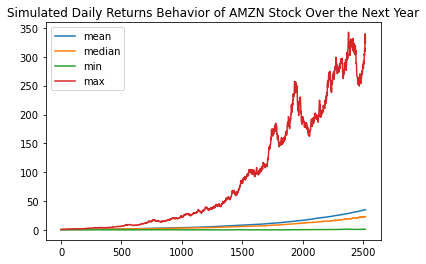

In [18]:
# Use the `plot` function to visually analyze the trajectory of AMZN stock daily returns on a trading day simulation
df_simulated_returns.plot(title="Simulated Daily Returns Behavior of AMZN Stock Over the Next Year")

In [19]:
# Set initial investment
initial_investment = 15000

# Multiply an initial investment by the daily returns of simulative stock prices to return the progression of daily returns in terms of money
cumulative_pnl = initial_investment * df_simulated_returns

# Display sample data
cumulative_pnl.head()

,mean,median,min,max
0,15000.000000,15000.000000,15000.000000,15000.000000
1,15027.664733,15023.003266,14245.606311,15924.414163
2,15048.772796,15048.593136,13639.483370,16208.238829
3,15081.476343,15074.595879,13403.827537,16337.387400
4,15124.278791,15126.986012,13260.417651,16595.730494


<AxesSubplot:title={'center':'Simulated Outcomes Behavior of AMZN Stock Over the Next Year'}>

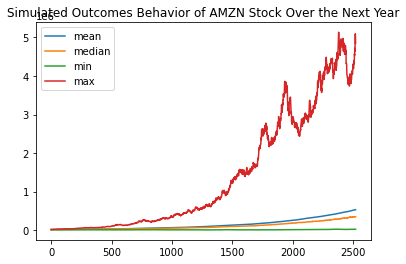

In [20]:
# Use the 'plot' function to create a chart of the simulated profits/losses
cumulative_pnl.plot(title="Simulated Outcomes Behavior of AMZN Stock Over the Next Year")